In [7]:
from pathlib import Path
import pandas as pd
from autots import AutoTS
import matplotlib.pyplot as plt

In [11]:
# Directorios
base_dir = Path().resolve()

# Rutas de CSVs
path_csv_dataset = base_dir.parent / "franco" / "data_set_integrado_modelo_final_futuro_binario.csv"

In [12]:
df_raw = pd.read_csv(path_csv_dataset)
df_raw.head()

,id_cotizacion,id_empresa,fecha,precio_apertura,precio_cierre,precio_max,precio_min,volumen_operado,variacion_porcentaje,nombre,...,total_noticias_positivas_std_3d,total_noticias_positivas_media_5d,total_noticias_positivas_std_5d,total_noticias_negativas_media_3d,total_noticias_negativas_std_3d,total_noticias_negativas_media_5d,total_noticias_negativas_std_5d,ratio_sent_positivo_negativo,diff_score_sentimiento,label_t_plus_1
0,901,10,2024-01-02,18.9,18.80,19.30,18.70,66824.55,-1.827676,AAPLD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
1,902,10,2024-01-03,19.0,18.80,19.15,18.25,81325.30,0.000000,AAPLD,...,6.000000,3.6,5.366563,6.333333,5.507571,3.8,5.215362,-1.119817,11.1142,SUBE
2,903,10,2024-01-04,18.8,18.95,19.05,18.20,97707.20,0.797872,AAPLD,...,3.785939,4.6,4.979960,9.000000,1.000000,5.4,4.979960,-0.408107,6.7009,NO_SUBE
3,904,10,2024-01-05,19.0,18.80,19.25,18.60,201923.66,-0.791557,AAPLD,...,3.785939,5.8,4.266146,9.000000,1.000000,7.2,4.086563,-0.799964,7.9571,SUBE
4,905,10,2024-01-08,19.1,19.35,19.50,18.85,151354.09,2.925532,AAPLD,...,1.527525,7.4,2.792848,10.666667,3.785939,10.2,2.774887,-0.690825,12.1479,NO_SUBE


In [4]:
df = df_raw.copy()

empresas = df['nombre'].unique().tolist()


In [13]:
empresas

['AAPLD', 'DESPD', 'KOD', 'MELID', 'MSFTD', 'NVDAD', 'TEND', 'VISTD', 'XOMD']

In [36]:
def llm_mapeo_num(df):
    df['valoracion_llm'] = df['valoracion_llm'].map({
    'positivo': 1,
    'neutro': 0,
    'negativo': -1
    })

    return df


def relleno_fechas(df):
    df['fecha'] = pd.to_datetime(df['fecha']).dt.normalize()
    # Establecer fecha como índice
    df = df.set_index('fecha')
    # Crear un rango diario completo desde la fecha mínima a la máxima
    rango_fechas = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(rango_fechas)
    # Rellenar valores faltantes hacia adelante (último valor conocido)
    df = df.ffill()
    # Restaurar la columna 'fecha'
    df = df.reset_index().rename(columns={'index': 'fecha'})
    return df


def recorte_df(df, empresa):
    nuevo_df = df[df['nombre'] == empresa]
    nuevo_df = relleno_fechas(nuevo_df)
    nuevo_df = llm_mapeo_num(nuevo_df)
    return nuevo_df


In [37]:
df_por_empresa = {
    empresa.lower(): recorte_df(df, empresa)
    for empresa in empresas
}

C:\Users\opera\AppData\Local\Temp\ipykernel_34040\295994172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fecha'] = pd.to_datetime(df['fecha']).dt.normalize()
C:\Users\opera\AppData\Local\Temp\ipykernel_34040\295994172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fecha'] = pd.to_datetime(df['fecha']).dt.normalize()
C:\Users\opera\AppData\Local\Temp\ipykernel_34040\295994172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

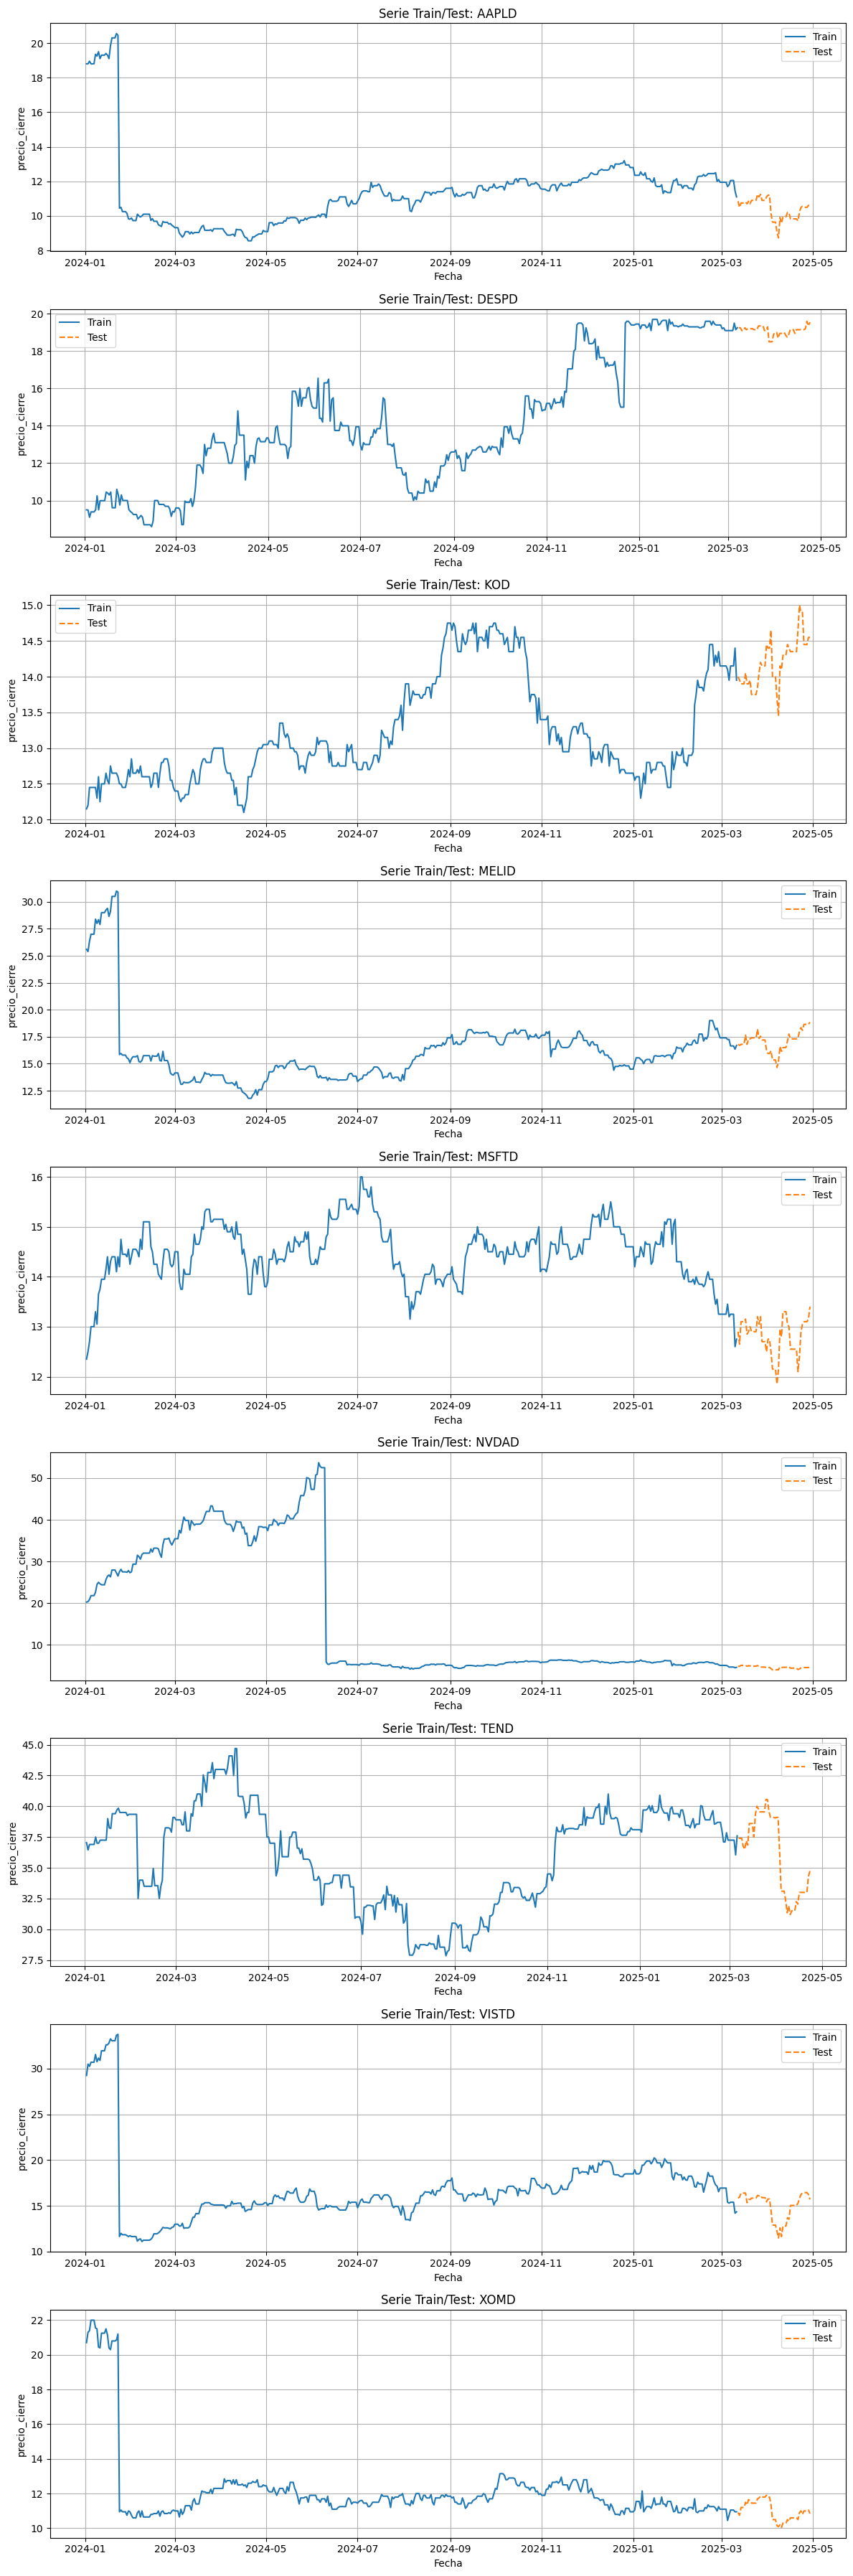

In [38]:
fig, axes = plt.subplots(nrows=len(df_por_empresa), ncols=1, figsize=(12, 4 * len(df_por_empresa)))

for ax, (nombre, df_empresa) in zip(axes, df_por_empresa.items()):
    corte = int(len(df_empresa) * 0.9)
    train = df_empresa.iloc[:corte]
    test = df_empresa.iloc[corte:]

    ax.plot(train['fecha'], train['precio_cierre'], label='Train')
    ax.plot(test['fecha'], test['precio_cierre'], label='Test', linestyle='--')
    ax.set_title(f'Serie Train/Test: {nombre.upper()}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('precio_cierre')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [39]:
def entrenar_modelos_por_empresa(df_dict, value_col='precio_cierre', date_col='fecha', regresores=None):
    modelos = {}
    predicciones = {}

    for nombre, df in df_dict.items():
        try:
            # Asegurar formato de fecha
            df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()
            df = df.dropna(subset=[value_col])

            # Separar en train/test
            corte = int(len(df) * 0.9)
            train = df.iloc[:corte].reset_index(drop=True)
            test = df.iloc[corte:].reset_index(drop=True)

            # Modelo AutoTS
            model = AutoTS(
                forecast_length=len(test),
                frequency='D',
                prediction_interval=0.9,
                ensemble=None,
                models_mode='deep',
                model_list='fast',
                max_generations=10,
                num_validations=3,
                no_negatives=True,
                n_jobs='auto',
                verbose=0
            )

            # Definir regresores si hay
            X_train = train[regresores] if regresores else None
            X_future = test[regresores] if regresores else None

            # Entrenamiento
            model = model.fit(
                train,
                date_col=date_col,
                value_col=value_col,
                future_regressor=X_train
            )

            # Predicción
            pred = model.predict(future_regressor=X_future)
            
            modelos[nombre] = model
            predicciones[nombre] = pred.forecast

        except Exception as e:
            print(f"Error al procesar {nombre}: {e}")
    
    return modelos, predicciones

In [40]:
def graficar_todas_predicciones(df_dict, forecasts_dict, value_col='precio_cierre', date_col='fecha'):
    num_empresas = len(df_dict)
    fig, axes = plt.subplots(nrows=num_empresas, ncols=1, figsize=(16, 4 * num_empresas))

    if num_empresas == 1:
        axes = [axes]  # asegurar que siempre sea iterable

    for ax, (nombre, df) in zip(axes, df_dict.items()):
        try:
            forecast = forecasts_dict[nombre]
            df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()

            # Separar train/test
            corte = int(len(df) * 0.9)
            train = df.iloc[:corte]
            test = df.iloc[corte:]
            
            # Alinear índices para que forecast y test comparen por fecha
            forecast.index = test[date_col].iloc[:len(forecast)].values

            # Graficar
            ax.plot(train[date_col], train[value_col], label='Train')
            ax.plot(test[date_col], test[value_col], label='Test', linestyle='--')
            ax.plot(forecast.index, forecast[value_col], label='Predicción', linestyle='dotted')

            ax.set_title(f'{nombre.upper()}: Precio de Cierre')
            ax.set_xlabel('Fecha')
            ax.set_ylabel('Precio')
            ax.legend()
            ax.grid(True)

        except Exception as e:
            print(f"Error al graficar {nombre}: {e}")

    plt.tight_layout()
    plt.show()

In [41]:
regresores = [
    'precio_apertura', 'volumen_operado',
    'total_noticias_negativas', 'suma_score_sentimiento_negativas',
    'total_noticias_positivas', 'suma_score_sentimiento_positivas',
    'valoracion_llm',
    'suma_score_sentimiento_positivas_lag_1', 'suma_score_sentimiento_positivas_lag_2', 'suma_score_sentimiento_positivas_lag_3',
    'suma_score_sentimiento_negativas_lag_1', 'suma_score_sentimiento_negativas_lag_2', 'suma_score_sentimiento_negativas_lag_3',
    'total_noticias_positivas_lag_1', 'total_noticias_positivas_lag_2', 'total_noticias_positivas_lag_3',
    'total_noticias_negativas_lag_1', 'total_noticias_negativas_lag_2', 'total_noticias_negativas_lag_3',
    'variacion_porcentaje_media_3d', 'variacion_porcentaje_std_3d',
    'variacion_porcentaje_media_5d', 'variacion_porcentaje_std_5d',
    'volumen_operado_media_3d', 'volumen_operado_std_3d',
    'volumen_operado_media_5d', 'volumen_operado_std_5d'
]

In [42]:
modelos, forecasts = entrenar_modelos_por_empresa(df_por_empresa, value_col='precio_cierre', regresores=regresores)

Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VECM') in model 23 in generation 0: VECM
Template Eval Error: ValueError('Only gave one variable to VECM') in model 24 in generation 0: VECM
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Template Eval Error: ValueError('matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 386 is different from 1651)') in model 48 in generation 0: BasicLinearModel
2025-01-22 00:00:00
2025-01-22 00:00:00
2025-01-22 00:00:00
Template Eval Error: ValueError('Model AverageValueNaive returned improper

  File "c:\Users\opera\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\opera\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\opera\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

Template Eval Error: ValueError('Only gave one variable to VECM') in model 102 in generation 0: VECM
Cassandra transformed data is all 0.0! Adding noise...
Template Eval Error: ModuleNotFoundError("No module named 'tensorflow'") in model 106 in generation 0: Cassandra
Template Eval Error: Exception('Transformer FIRFilter failed on fit') in model 108 in generation 0: GLM
Template Eval Error: ValueError('Only gave one variable to VECM') in model 110 in generation 0: VECM
Template Eval Error: ValueError('Shape of passed values is (21, 1), indices imply (49, 1)') in model 113 in generation 0: MAR
Template Eval Error: ValueError('Only gave one variable to VECM') in model 116 in generation 0: VECM
Template Eval Error: LinAlgError('SVD did not converge') in model 120 in generation 0: BasicLinearModel
Template Eval Error: ValueError('Only gave one variable to VAR') in model 122 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 127 in generation 0: V

Error al graficar kod: 'kod'
Error al graficar tend: 'tend'


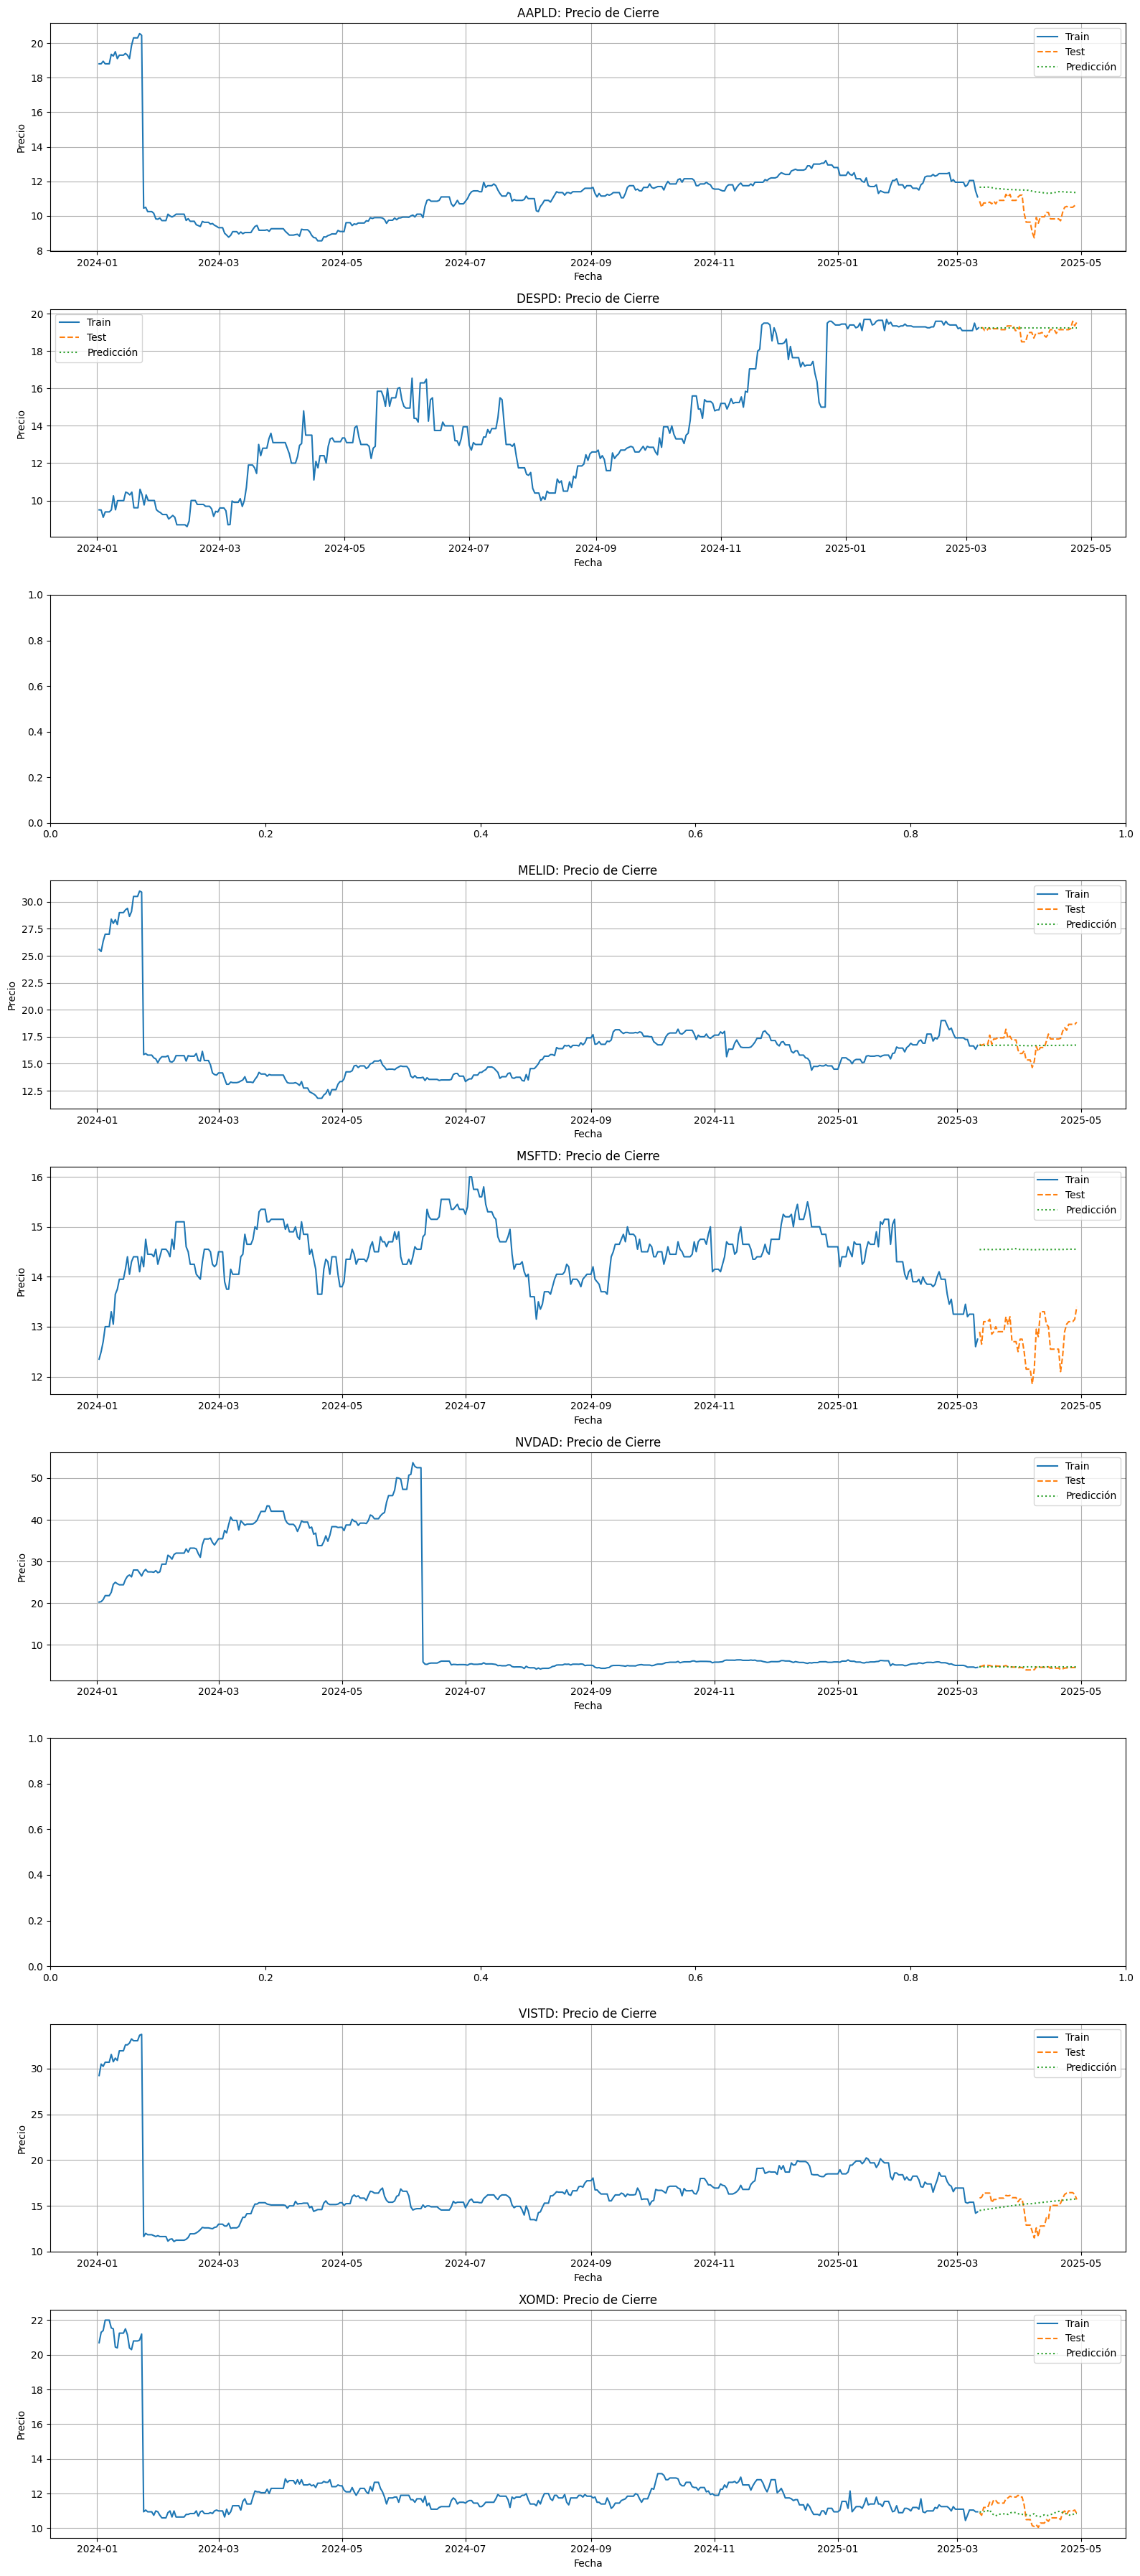

In [43]:
graficar_todas_predicciones(df_por_empresa, forecasts, value_col='precio_cierre')

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_modelos(df_dict, forecasts_dict, value_col='precio_cierre', date_col='fecha'):
    resultados = {}

    for nombre, df in df_dict.items():
        try:
            forecast = forecasts_dict[nombre]
            df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()
            corte = int(len(df) * 0.9)
            test = df.iloc[corte:]

            # Alinear índices
            forecast.index = test[date_col].iloc[:len(forecast)].values
            y_true = test[value_col].iloc[:len(forecast)].values
            y_pred = forecast[value_col].values

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))

            resultados[nombre] = {'MAE': mae, 'RMSE': rmse}

        except Exception as e:
            print(f"Error al calcular métricas para {nombre}: {e}")
    
    return resultados

In [49]:
metricas = calcular_metricas_modelos(df_por_empresa, forecasts, value_col='precio_cierre')

for nombre, m in metricas.items():
    print(f"{nombre.upper()} → MAE: {m['MAE']:.4f}, RMSE: {m['RMSE']:.4f}")

Error al calcular métricas para kod: 'kod'
Error al calcular métricas para tend: 'tend'
AAPLD → MAE: 1.0723, RMSE: 1.1980
DESPD → MAE: 0.2021, RMSE: 0.2773
MELID → MAE: 0.8211, RMSE: 1.0134
MSFTD → MAE: 1.7390, RMSE: 1.7758
NVDAD → MAE: 0.2431, RMSE: 0.3116
VISTD → MAE: 1.2925, RMSE: 1.5766
XOMD → MAE: 0.4738, RMSE: 0.5640
